# BERT Topic Modeling of Survey Measurements of Masculinity

Purpose: Employ BERT, a topic modeling algorithm, to automatically cluster text data into particular topics. In this particular example, I am analyzing the common topics/themes of ~500 survey questions from surveys that measure masculinity. 

Topic Modeling Information: https://maartengr.github.io/BERTopic/index.html

Inspiration: https://github.com/pinecone-io/examples/tree/master/learn/experimental/algos-and-libraries/bertopic

## Imports and Setup

In [70]:
from bertopic import BERTopic
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [71]:
df = pd.read_csv('../Data/Questions_Final.csv')

# Comment the following line if evaluating more than the CMNI
df = df[df["Scale"] == "Conformity to Masculine Norms Inventory"]

print(df.shape)
# Put reviews in a list
docs = df['Question Text'].to_list()

(94, 7)


## Default BERTopic

In [72]:
# Removing stop words?
from sklearn.feature_extraction.text import CountVectorizer

vectorizer_model = CountVectorizer(stop_words="english")
topic_model = BERTopic(vectorizer_model=vectorizer_model, nr_topics='auto')

In [73]:
topics, probs = topic_model.fit_transform(docs)

In [74]:
topic_info_df = topic_model.get_topic_info()
topic_info_df

,Topic,Count,Name,Representation,Representative_Docs
0,-1,23,-1_gay_help_thought_men,"[gay, help, thought, men, ask, charge, women, ...","[I never ask for help, It would be awful if pe..."
1,0,27,0_feelings_emotional_sex_person,"[feelings, emotional, sex, person, sexual, wom...","[Feelings are important to show, I would only ..."
2,1,23,1_violence_risks_way_kind,"[violence, risks, way, kind, justified, prefer...","[Violence is almost never justified, Taking da..."
3,2,21,2_work_important_winning_win,"[work, important, winning, win, things, comes,...","[It is important for me to win, Work is not th..."


In [75]:
# Visualize Topics
# topic_model.visualize_topics().show()

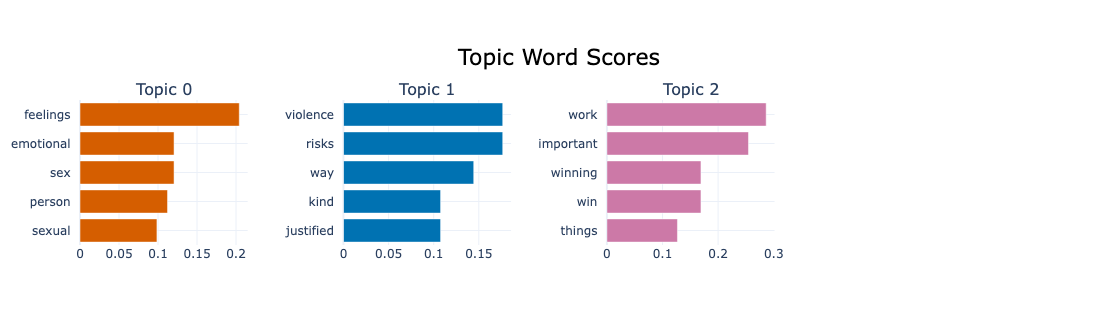

In [76]:
bar_chart = topic_model.visualize_barchart(top_n_topics=10)

# Update filepath as needed
bar_chart.write_image("../Visualizations/BERTopic_Bar_Chart.png", width=800, height=600)
bar_chart

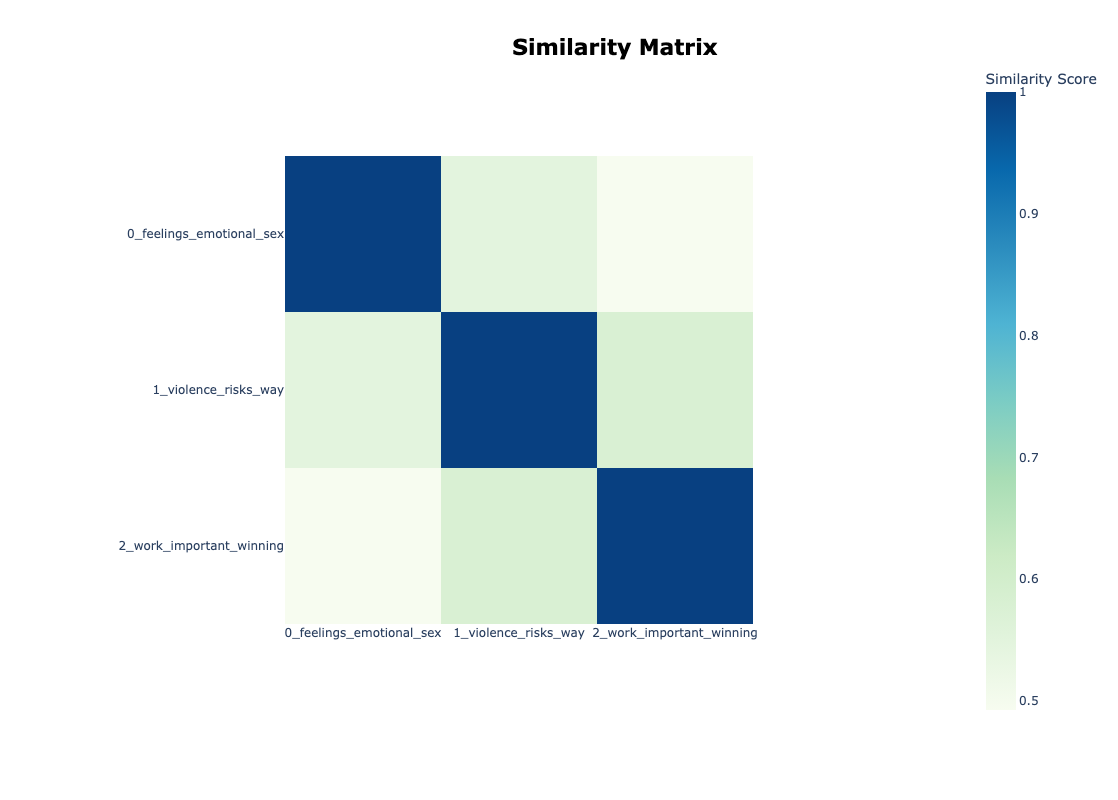

In [77]:
heat_map = topic_model.visualize_heatmap()

# Update filepath as needed
heat_map.write_image("../Visualizations/BERTopic_Heat_Map.png", width=800, height=600)
heat_map

## Investigate Factor Loadings of Original CMNI vs. BERTopic

In [9]:
full_BERTopic_info = topic_model.get_document_info(docs)

# Join the "Document" column of full_BERTopic_info with the "Question Text" column of df
merged_df = pd.merge(df, full_BERTopic_info, left_on="Question Text", right_on="Document", how="inner")

# Drop the duplicate "Document" column if needed
merged_df.drop("Document", axis=1, inplace=True)

merged_df_subset = merged_df[["Factor", "Question Text", "Topic", "Name"]]
# Rename columns for readability
merged_df_subset = merged_df_subset.rename(columns={
    "Question Text": "Document",
    "Factor": "Original Factor",
    "Topic": "BERTopic Topic",
    "Name": "BERTopic Name"
})

merged_df_subset = merged_df_subset[['Document', 'Original Factor', 'BERTopic Topic', 'BERTopic Name']]
merged_df_subset.head()

,Document,Original Factor,BERTopic Topic,BERTopic Name
0,It is best to keep your emotions hidden,Emotional Control,1,1_feelings_sex_emotional_person
1,In general‚ I will do anything to win,Winning,0,0_work_important_winning_win
2,If I could‚ I would frequently change sexual p...,Playboy,2,2_risks_general_risky_frequently
3,If there is going to be violence‚ I find a way...,Violence,-1,-1_gay_women_help_men
4,It is important to me that people think I am h...,Disdain for Homosexuals,-1,-1_gay_women_help_men


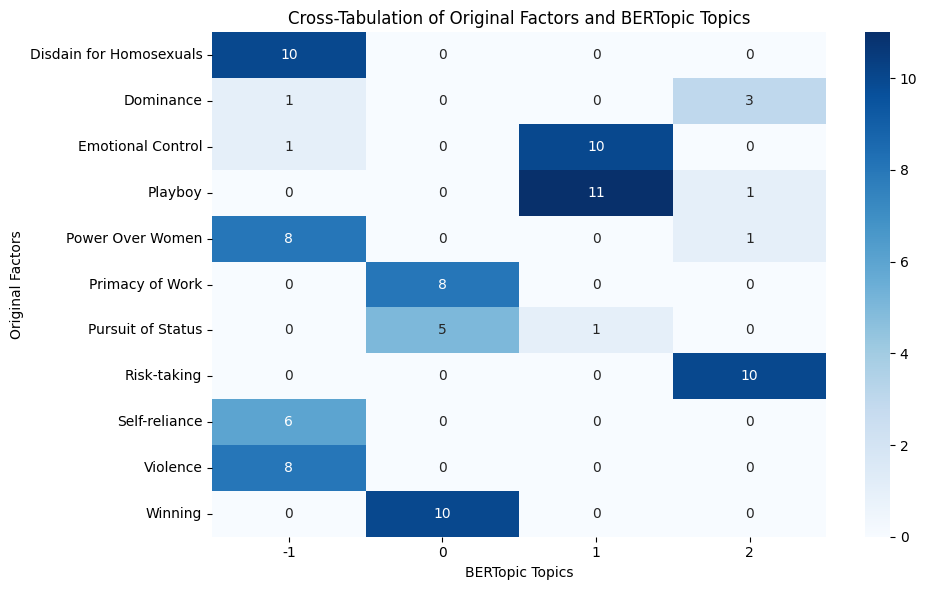

In [10]:
# Create a cross-tabulation table to count the frequency of occurrences of each combination of "Original Factor" and "BERTopic Topic".
cross_tab = pd.crosstab(merged_df_subset["Original Factor"], merged_df_subset["BERTopic Topic"])

# Heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(cross_tab, cmap="Blues", annot=True, fmt="d")
plt.title("Cross-Tabulation of Original Factors and BERTopic Topics")
plt.xlabel("BERTopic Topics")
plt.ylabel("Original Factors")
plt.xticks(rotation=0)
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig("../Visualizations/BERTopic_CrossTab.png")
plt.show()

In [11]:
from scipy.stats import chi2_contingency

# Assuming you have a dataframe named merged_df with "Original Factor" and "BERTopic Topic" columns
# Convert text values to categorical variables
merged_df_subset["Original Factor"] = pd.Categorical(merged_df_subset["Original Factor"])
merged_df_subset["BERTopic Topic"] = pd.Categorical(merged_df_subset["BERTopic Topic"])

# Create a contingency table
contingency_table = pd.crosstab(merged_df_subset["Original Factor"], merged_df_subset["BERTopic Topic"])

# Perform chi-squared test of independence to determine whether there is a stat. sig. assoc. 
# to see whether obs. freqs. in the contingency table differ significantly.
chi2, p_value, dof, expected = chi2_contingency(contingency_table)

print("Chi-squared statistic:", chi2)
print("P-value:", p_value)
print("Degrees of freedom:", dof)
print("Expected frequencies table:")
print(expected)

Chi-squared statistic: 244.1734031002108
P-value: 2.0125857006791628e-35
Degrees of freedom: 30
Expected frequencies table:
[[3.61702128 2.44680851 2.34042553 1.59574468]
 [1.44680851 0.9787234  0.93617021 0.63829787]
 [3.9787234  2.69148936 2.57446809 1.75531915]
 [4.34042553 2.93617021 2.80851064 1.91489362]
 [3.25531915 2.20212766 2.10638298 1.43617021]
 [2.89361702 1.95744681 1.87234043 1.27659574]
 [2.17021277 1.46808511 1.40425532 0.95744681]
 [3.61702128 2.44680851 2.34042553 1.59574468]
 [2.17021277 1.46808511 1.40425532 0.95744681]
 [2.89361702 1.95744681 1.87234043 1.27659574]
 [3.61702128 2.44680851 2.34042553 1.59574468]]


## How does BERTopic work?

**Data -> Sentence Embeddings** (transforming text into machine readable version - usually 768/384 dimensions)


Sentence Embeddings via Transformers Architecture
    Transformers use an encode/decode network. English into a context vector and then decoded. However the context vector is so complex this creates a bottleneck into the decoder. So the attention mechanism tells which decoder parts to focus on. In 2017, attention paper released that found they can remove the recurrent parts of the network and just keep the attention mechanism so high-performing. (called a transformer).

New attention (transformer): 
(1) have positional encoding (sense of order of the tokens)
(2) self-attention (how a word is applied to all other words in the sentence). Rather than embed the meaning of the individual word, it embeds the context of the words around it.
(3) multi-head attention (parallelization)

We can take a pre-trained core (e.g. BERT) and can fine-tune it.

So now we have a vector with 768/384 dimensions.

    
**Embeddings -> UMAP** (dimensionality reduction)

UMAP helps us compress embeddings into a smaller vector small (2 or 3 dimensions).
Understands density of particular areas in the data through k_nearest_neighbors. Understands distance between different vector rows


**UMAP -> clustering with HDBSCAN**
Here we can define the number of points needed to define a cluster. (by default something like 5)

(Number of topics can be determined by how we set parameters like min_cluster_size and min_samples (how dense the core of a cluster needs to be to group))

**clustering with HDBSCAN -> C-TF-IDF**
Looks at freq. of words with a particular cluster, and see how common these words are.



## Customizing BERTopic

Inspiration: https://www.pinecone.io/learn/bertopic/

In [94]:
docs = df['Question Text'].to_list()

In [95]:
from sentence_transformers import SentenceTransformer
from umap import UMAP
from hdbscan import HDBSCAN

# Most popular model - Hugging Face: https://huggingface.co/sentence-transformers?sort_models=downloads#models
embedding_model = SentenceTransformer('all-MiniLM-L6-v2')

# n_neighbors identifies the kth nearest neighbors (Default is 15, recommended between 3 and 5)
# n_components represents the reduced dimension space we embed the data into (Default is 2)
# min_dist controls the minimum distance points are allowed to be in the final low dimensional representation (Default set to 0.1)

#setting a random state allows us to fully reproduce the results each time we run the model. prevents stochastic behavior. (https://umap-learn.readthedocs.io/en/latest/reproducibility.html)
umap_model = UMAP(n_neighbors=3, n_components=2, min_dist=0.1, random_state=42)

# min_cluster_size is the minimum # of points required for a cluster. It is set to 5/10 by default, and has a min. value of 2.
# min_samples is the minimum # of points required to form a core within a cluster. It is set to min_cluster_size by default, and has a min. value of 1.
#      Core points are data points that have at least min_samples neighbors within a specified radius.
#      In other words, min_samples influences how densely points must be distributed within a cluster

# Summary: min_cluster_size filters out small clusters based on the number of samples they contain, while min_samples controls the density of clusters by specifying the minimum number of neighbors required for a point to be considered a core point. 

# allow_single_cluster is set to true to see if a single overriding cluster exists.
# The gen_min_span_tree and prediction_data params are required for integrating with BERTopic and visualizing clusters later on.
hdbscan_model = HDBSCAN(min_cluster_size=10, min_samples=10,
                        allow_single_cluster=True,
                        gen_min_span_tree=True,
                        prediction_data=True)

In [96]:
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords

stopwords = list(stopwords.words('english'))

# we add this to remove stopwords that can pollute topcs
vectorizer_model = CountVectorizer(ngram_range=(1, 2), stop_words=stopwords)

In [97]:
from bertopic import BERTopic

model = BERTopic(
    umap_model=umap_model,
    hdbscan_model=hdbscan_model,
    embedding_model=embedding_model,
    vectorizer_model=vectorizer_model,
    top_n_words=5,
    language='english',
    calculate_probabilities=True,
    verbose=True
)
topics, probs = model.fit_transform(docs)

2024-05-26 19:16:03,341 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

2024-05-26 19:16:03,517 - BERTopic - Embedding - Completed ✓
2024-05-26 19:16:03,517 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-05-26 19:16:03,826 - BERTopic - Dimensionality - Completed ✓
2024-05-26 19:16:03,826 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-05-26 19:16:03,832 - BERTopic - Cluster - Completed ✓
2024-05-26 19:16:03,834 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-05-26 19:16:03,840 - BERTopic - Representation - Completed ✓


In [98]:
# WOAH. When we set min_cluster_size=2, min_samples=1. We see 29 topics. 
# However, viewing the intertopic distance map, we notice a lot of overlapping. Grouping of approximately 9 topics. 

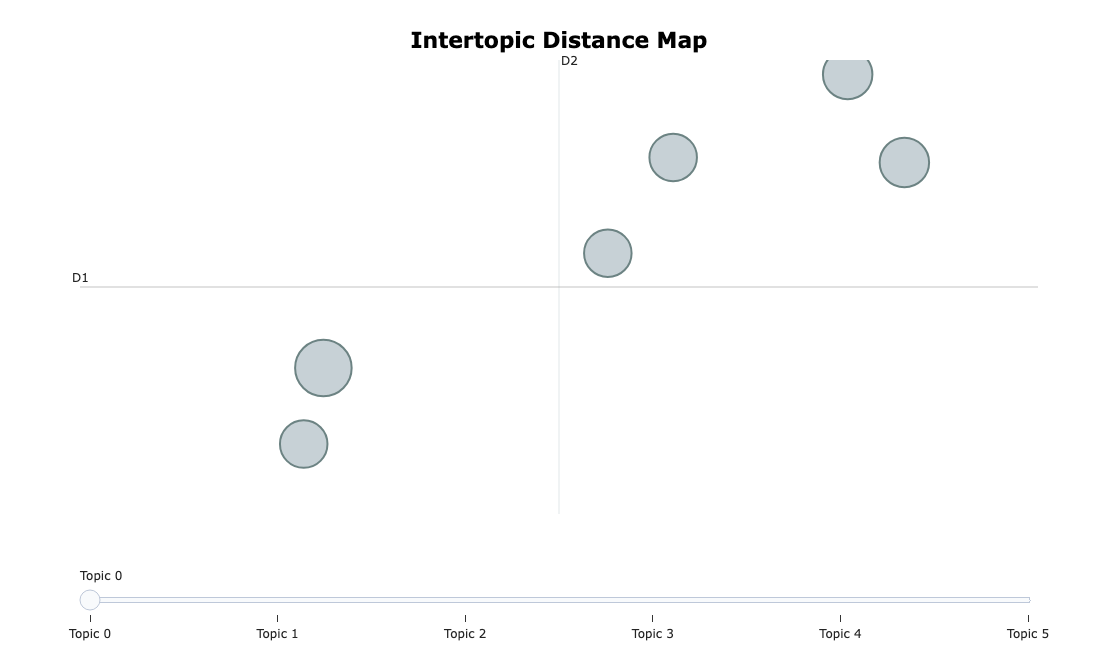

In [99]:
# Visualize Topics
model.visualize_topics().show()

## Evaluation Metrics

In [100]:
## NPMI

import gensim.corpora as corpora
from gensim.models.coherencemodel import CoherenceModel


cleaned_docs = topic_model._preprocess_text(docs)
analyzer = vectorizer_model.build_analyzer()
tokens = [analyzer(doc) for doc in cleaned_docs]
dictionary = corpora.Dictionary(tokens)
corpus = [dictionary.doc2bow(token) for token in tokens]

topic_words = [
   [word for word, probs in model.get_topic(topic) if word != ""] for topic in topics
]
topic_words = [[words for words, _ in model.get_topic(topic)] 
            for topic in range(len(set(topics))-1)]

# Evaluate
coherence_model = CoherenceModel(topics=topic_words, 
                             texts=tokens, 
                             corpus=corpus,
                             dictionary=dictionary, 
                             coherence='c_npmi')
coherence = coherence_model.get_coherence()

# coherence score of -0.433 is very low, indicative that the words across the topics are similar semantically (but this makes sense since all from the same survey?) 
coherence

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

-0.05865264460253312

In [102]:
# Silhouette Score
# Measures how similar an object is to its own cluster compared to other clusters.
# Ranges from -1 to 1, where higher values indicate better-defined clusters.
# A score of 1 indicates that the object is well-matched to its own cluster and poorly matched to neighboring clusters.
from sklearn.metrics import silhouette_score

embeddings = embedding_model.encode(docs, show_progress_bar=False)

# Generate `X` and `labels` only for non-outlier topics (as they are technically not clusters)
umap_embeddings = model.umap_model.transform(embeddings)
indices = [index for index, topic in enumerate(topics) if topic != -1]
X = umap_embeddings[np.array(indices)]
labels = [topic for index, topic in enumerate(topics) if topic != -1]

# Calculate silhouette score
silhouette_score(X, labels)

0.7838562